In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.optimize import leastsq, minimize


In [ ]:
num_timesteps = 100
timesteps = np.arange(0,num_timesteps) #in hours?

In [ ]:

def simulate_rna_concentrations(production_rate, circularizing_fraction_array, max_t_units = 7, min_t_units=0, params_dict = None, suppress_plots=True):
  #parameters fixed across instantiatnions
  if params_dict is None:
    decay_rate_circ = .2
    decay_rate_linear = 10
    homer1a_fraction = .5
  else:
    decay_rate_circ = params_dict['decay_rate_circ']
    decay_rate_linear = params_dict['decay_rate_linear']
    homer1a_fraction = params_dict['homer1a_fraction']


  num_timesteps = len(production_rate)
  dt = (max_t_units-min_t_units)/num_timesteps
  timesteps = (np.arange(0,num_timesteps)*dt )+ min_t_units
  zero_index = round(-1*min_t_units/dt)

  pre_splice_homer = np.zeros(num_timesteps)
  homer1a = np.zeros(num_timesteps)
  circ_homer = np.zeros(num_timesteps)

  for t in range(num_timesteps-1):
    converted_to_1a = homer1a_fraction*pre_splice_homer[t]*dt
    rest_to_circ = pre_splice_homer[t]*dt*circularizing_fraction_array[t]
    delta_homer = production_rate[t] - decay_rate_linear*dt*pre_splice_homer[t] - converted_to_1a
    homer1a_to_circ = homer1a[t]*dt*circularizing_fraction_array[t]
    delta_homer1a = converted_to_1a - decay_rate_linear*dt*homer1a[t]
    delta_circular = rest_to_circ + homer1a_to_circ - decay_rate_circ*dt*circ_homer[t]

    pre_splice_homer[t+1] = pre_splice_homer[t]+delta_homer
    homer1a[t+1] = homer1a[t]+delta_homer1a
    circ_homer[t+1] = circ_homer[t]+delta_circular

  normalized_linear_amount = homer1a/(homer1a[zero_index])
  normalized_circular_amount = circ_homer/(circ_homer[zero_index])

  if not(suppress_plots):
    plt.plot(timesteps,normalized_linear_amount , label='linear simulated')
    plt.plot(timesteps, normalized_circular_amount, label='circ simulated')
    plt.plot(timesteps, production_rate, label='transcription rate')
    plt.plot(timesteps, circularizing_fraction_array*100, label='circularizing percent')

    plt.xlabel('Day')
    plt.ylabel('Normalized expression level (relative to T=0)')
    plt.legend()
  return timesteps, normalized_linear_amount, normalized_circular_amount


(array([-1.        , -0.97916667, -0.95833333, ..., 69.9375    ,
        69.95833333, 69.97916667]),
 array([0.        , 0.        , 0.04534398, ..., 2.0001111 , 2.00020078,
        2.00028301]),
 array([0.        , 0.        , 0.0052454 , ..., 1.13122815, 1.13157703,
        1.13192459]))

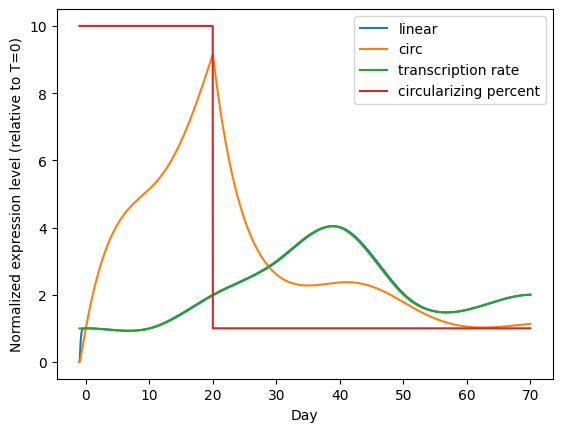

In [ ]:
#Test changes here
params_dict = {
  'decay_rate_circ' : .2,
  'decay_rate_linear' : 10,
  'homer1a_fraction' : .5,
  }

change_day_list_t = [10,20,30,40,50,70]
transcription_level_list = [1,2,3,4,2, 2]

change_day_list_c = [10, 20]
circularizing_fraction_list = [.1, .01]

#time length = 60 days
#lets make each timestep 10 minutes
steps_per_hour = 2
max_t_units = 70 #days
min_t_units = -1 #days

def get_timestep_from_day_of_change(day, steps_per_hour, timesteps_before_0):
  return int(day*24*steps_per_hour+timesteps_before_0)

def create_production_rate(transcription_level_list, change_day_list, steps_per_hour,  max_t_units, min_t_units, interpolate=False, add_zero=True):
  #add the zero timepoint at a transciption level of 1 (this level is fixed, not allowed to vary in optimization)
  assert len(transcription_level_list) == len(change_day_list)
  this_transcription_level_list = list(transcription_level_list.copy())
  this_change_day_list = change_day_list.copy()
  if add_zero:
    this_transcription_level_list.insert(0, 1)
    this_change_day_list.insert(0, 0)

  timesteps_before_0 = -1*min_t_units*24*steps_per_hour
  num_timesteps = (max_t_units-min_t_units)*24*steps_per_hour

  step_size = (max_t_units - min_t_units)/num_timesteps
  x = np.arange(min_t_units, max_t_units, step_size)
  if interpolate=='linear':
    production_rate = np.interp(x, this_change_day_list, this_transcription_level_list)
  elif interpolate:
    cs = CubicSpline(this_change_day_list, this_transcription_level_list,
                     bc_type = 'clamped')
    production_rate = cs(x)
  else:
    production_rate = np.ones(num_timesteps)*this_transcription_level_list[0]
    for i, transciption_level in enumerate(this_transcription_level_list):
      change_day = this_change_day_list[i]
      change_timestep = get_timestep_from_day_of_change(change_day, steps_per_hour, timesteps_before_0 )
      production_rate[change_timestep:] = transciption_level
  return production_rate


production_rate = create_production_rate(transcription_level_list, change_day_list_t, steps_per_hour,  max_t_units, min_t_units, interpolate=True)
circularizing_fraction_array = create_production_rate(circularizing_fraction_list, change_day_list_c, steps_per_hour,  max_t_units, min_t_units, interpolate=False, add_zero=False)
#plt.plot(production_rate)
#plt.plot(circularizing_fraction_array)
simulate_rna_concentrations(production_rate, circularizing_fraction_array, max_t_units = max_t_units, min_t_units = min_t_units, suppress_plots = False)

In [ ]:
def compute_aic_bic(rss, k, n):
  aic = 2*k+n*np.log(rss/n)
  #aicc = aic + (2*k**2 + 2*k)/(n-k-1)
  #print(f'aicc: {aicc}')
  bic = n*np.log(rss/n) + k * np.log(n)
  return aic, bic


def compare_simulated_to_measured(params_dict, max_t_units, min_t_units,
                                  change_day_list_t, transcription_level_list,
                                  change_day_list_c, circularizing_fraction_list,
                                  day_list, circ_homer_levels,
                                  linear_homer_levels,
                                  suppress_plots=True):
  production_rate = create_production_rate(transcription_level_list, change_day_list_t, steps_per_hour,  max_t_units, min_t_units, interpolate='linear')

  circularizing_fraction_array = create_production_rate(circularizing_fraction_list, change_day_list_c, steps_per_hour,  max_t_units, min_t_units, interpolate=False, add_zero=False)

  #plt.plot(production_rate)
  timesteps, homer1a_cont, circhomer_cont = simulate_rna_concentrations(
      production_rate, circularizing_fraction_array,
      max_t_units = max_t_units, min_t_units = min_t_units,
      params_dict=params_dict, suppress_plots=suppress_plots)
  #print('done simulating')
  #print(f'len circhomer_cont: {len(homer1a_cont)}')
  #print(homer1a_cont)

  norm_circ_homer_levels = circ_homer_levels/circ_homer_levels[0]
  norm_linear_homer_levels = linear_homer_levels/linear_homer_levels[0]
  #I think its already normalized??

  homer1a_predicted = np.interp(day_list, timesteps, homer1a_cont)
  circhomer_predicted = np.interp(day_list, timesteps, circhomer_cont)
  n = len(homer1a_predicted)+len(circhomer_predicted)

  print(f'norm_linear_homer_levels: {norm_linear_homer_levels}')
  print(f'homer1a_predicted: {homer1a_predicted}')
  print(f'circhomer_predicted: {circhomer_predicted}')
  print(f'norm_circ_homer_levels: {norm_circ_homer_levels}')

  squared_error_homer1a = np.sum((homer1a_predicted - norm_linear_homer_levels)**2)
  print(f'squared_error_homer1a: {squared_error_homer1a}')
  squared_error_circ = np.sum((circhomer_predicted - norm_circ_homer_levels)**2)
  print(f'squared_error_circ: {squared_error_circ}')
  rss = (squared_error_homer1a+squared_error_circ)
  print(f'RSS: {rss}')

  k = len(change_day_list) + len(params_dict)+len(change_day_list_c)*2
  aic, bic = compute_aic_bic(rss, k, n)

  if not(suppress_plots):
    print(f'aic: {aic}')
    print(f'bic: {bic}')
    plt.scatter(day_list,norm_linear_homer_levels , label='linear measured')
    plt.scatter(day_list, norm_circ_homer_levels, label='circ measured')
    plt.xlabel('Day')
    plt.ylabel('Normalized expression level (relative to T=0)')
    plt.legend()
  return timesteps, homer1a_cont, circhomer_cont, aic

In [ ]:
def unpack_parameters(guessed_params, num_circularizing_levels=1):
  params_dict = {}
  this_guessed_params = list(guessed_params).copy()

  params_dict['homer1a_fraction'] = this_guessed_params.pop()
  params_dict['decay_rate_linear'] = this_guessed_params.pop()
  params_dict['decay_rate_circ'] = this_guessed_params.pop()
  circularizing_fraction_list = this_guessed_params[-num_circularizing_levels:]
  change_day_list_c = this_guessed_params[-2*num_circularizing_levels:-num_circularizing_levels]

  this_transcription_level_list = this_guessed_params[:-2*num_circularizing_levels]
  #print(params_dict)
  #print(f'this_transcription_level_list: {this_transcription_level_list}')
  #print(f'circularizing_fraction_list: {circularizing_fraction_list}')
  #print(f'change_day_list_c: {change_day_list_c}')
  #print(f'params_dict: {params_dict}')
  #raise()

  return params_dict, this_transcription_level_list, circularizing_fraction_list, change_day_list_c

def error_func_scalar_homer(
    guessed_params,#<- transciption_level_list with the other parameters appended
    #fixed_params,
    max_t_units, min_t_units, change_day_list_t,
    num_circularizing_levels,
    #targets
    circ_homer_levels, linear_homer_levels, change_relationship = False
    ):

  #print(guessed_params)
  #unpack the guessed_parameters
  params_dict, this_transcription_level_list, circularizing_fraction_list, change_day_list_c  = unpack_parameters(guessed_params, num_circularizing_levels)
  #print(change_day_list)
  #print(f'this_transcription_level_list: {this_transcription_level_list}')
  #print(f'circularizing_fraction_list: {circularizing_fraction_list}')
  #print(f'change_day_list_c: {change_day_list_c}')
  assert len(change_day_list_t) == len(this_transcription_level_list)

  #Apply the function
  production_rate = create_production_rate(this_transcription_level_list, change_day_list_t, steps_per_hour,  max_t_units, min_t_units, interpolate='linear')
  circularizing_fraction_array = create_production_rate(circularizing_fraction_list, change_day_list_c, steps_per_hour,  max_t_units, min_t_units, interpolate=False, add_zero=False)

  timesteps, homer1a_cont, circhomer_cont = simulate_rna_concentrations(
      production_rate, circularizing_fraction_array,
      max_t_units = max_t_units, min_t_units = min_t_units,
      params_dict=params_dict, suppress_plots=True)

  #Now compute the error
  norm_circ_homer_levels = circ_homer_levels/circ_homer_levels[0]
  norm_linear_homer_levels = linear_homer_levels/linear_homer_levels[0]

  homer1a_predicted = np.interp(day_list, timesteps, homer1a_cont)
  circhomer_predicted = np.interp(day_list, timesteps, circhomer_cont)
  n = len(homer1a_predicted)+len(circhomer_predicted)

  squared_error_homer1a = np.sum((homer1a_predicted - norm_linear_homer_levels)**2)
  squared_error_circ = np.sum((circhomer_predicted - norm_circ_homer_levels)**2)
  rss = (squared_error_homer1a+squared_error_circ)
  if np.isnan(rss):
    rss = 100000000000 #just needs to be bigger than error for a reasonable set of parameters
  return rss


In [ ]:
def fit_system(params_dict,
               max_t_units, min_t_units,
               change_day_list_t,
               transcription_level_list,
               change_day_list_c,
               circularizing_fraction_list,
               day_list,
               circ_homer_levels,
               linear_homer_levels,
               suppress_plots = False,
               ):

    guessed_params = transcription_level_list.copy()
    bounds = [(0,50) for param in guessed_params]

    guessed_params.extend(change_day_list_c)
    bounds.extend([(min_t_units,max_t_units)]*len(change_day_list_c))

    guessed_params.extend(circularizing_fraction_list)
    bounds.extend([(0,.5)]*len(change_day_list_c))
    num_circularizing_levels = len(circularizing_fraction_list)
    assert len(circularizing_fraction_list) == len(change_day_list_c)

    guessed_params.append(params_dict['decay_rate_circ'])
    bounds.append((0,50))

    guessed_params.append(params_dict['decay_rate_linear'])
    bounds.append((0,50))

    guessed_params.append(params_dict['homer1a_fraction'])
    bounds.append((0,.5))


    print(f'Initial parameter guesses: {guessed_params}')
    rss = error_func_scalar_homer(
        guessed_params,
        max_t_units, min_t_units, change_day_list_t, num_circularizing_levels,
        circ_homer_levels, linear_homer_levels
        )
    print(f'Hand fit RSS: {rss}')


    result = minimize(error_func_scalar_homer, guessed_params,
                      args=(
                            max_t_units,
                            min_t_units,
                            change_day_list_t,
                            num_circularizing_levels,
                            circ_homer_levels,
                            linear_homer_levels
                            ),
                      bounds = bounds,
                      )

    fit_params = result.x
    rss = error_func_scalar_homer(
        fit_params,
        max_t_units, min_t_units, change_day_list_t, num_circularizing_levels,
        circ_homer_levels, linear_homer_levels
        )
    print(f"fit parameter values: {np.array2string(fit_params, precision=2, floatmode='fixed')}")
    print(f'Best fit RSS: {rss}')

    if not(suppress_plots):
        best_params_dict, best_transcription_level_list, best_c_frac_list, best_change_day_list_c = unpack_parameters(fit_params, num_circularizing_levels)
        compare_simulated_to_measured(best_params_dict, max_t_units, min_t_units,
                                          change_day_list_t,best_transcription_level_list,
                                          best_change_day_list_c, best_c_frac_list,
                                          day_list, circ_homer_levels,
                                            linear_homer_levels, suppress_plots = suppress_plots)



norm_linear_homer_levels: [ 1. 12. 19.  3.  2.]
homer1a_predicted: [ 1.         10.43943154 21.90495116  3.05620933  2.        ]
circhomer_predicted: [1.         1.06775879 1.50881769 2.11444274 2.30555014]
norm_circ_homer_levels: [1.  1.5 2.  2.5 3. ]
squared_error_homer1a: 10.877274650417231
squared_error_circ: 1.0590075272390638
RSS: 11.936282177656295
aic: 23.76997591077353
bic: 27.098411933708032
CPU times: user 53.8 ms, sys: 2 ms, total: 55.8 ms
Wall time: 55 ms


(-1.0, 3.0)

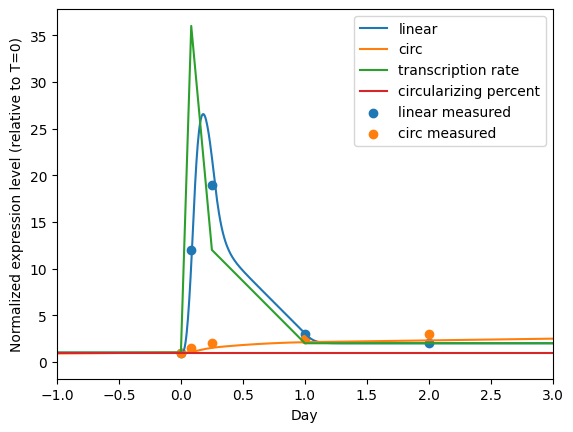

In [ ]:
%%time
#Bicuculin experiments
params_dict = {
  'decay_rate_circ': .01 ,
  'decay_rate_linear': 25 ,
  'homer1a_fraction': 0.5 ,
  }

max_t_units = 3 #days
min_t_units = -10 #days

change_day_list_t = [2/24, 6/24, 24/24, 48/24]
transcription_level_list = [12*3, 4*3, 2, 2]

day_list = [0,2/24, 6/24, 24/24, 48/24]
circ_homer_levels = np.array([1, 1.5, 2, 2.5, 3])
linear_homer_levels = np.array([1, 12, 19, 3, 2])

change_day_list_c = [0, 1.5]
circularizing_fraction_list = [.01, .01]

compare_simulated_to_measured(params_dict, max_t_units, min_t_units,
                                  change_day_list_t, transcription_level_list,
                                  change_day_list_c, circularizing_fraction_list,
                                  day_list, circ_homer_levels,
                                    linear_homer_levels, suppress_plots = False)
plt.xlim(-1, 3)


Initial parameter guesses: [36, 12, 2, 2, 0, 0.01, 0.01, 25, 0.5]
Hand fit RSS: 11.936282177656295


<ipython-input-51-b30b937a899e>:34: RuntimeWarning: invalid value encountered in divide
  normalized_linear_amount = homer1a/(homer1a[zero_index])


fit parameter values: [3.57e+01 8.43e+00 2.49e+00 2.00e+00 0.00e+00 1.00e-02 2.02e-01 2.89e+01
 2.94e-06]
Best fit RSS: 0.26850551329895017
norm_linear_homer_levels: [ 1. 12. 19.  3.  2.]
homer1a_predicted: [ 1.         12.00417933 19.0008814   3.03865859  2.03386362]
circhomer_predicted: [1.         1.14595343 2.0341816  2.70749453 2.68971835]
norm_circ_homer_levels: [1.  1.5 2.  2.5 3. ]
squared_error_homer1a: 0.0026594754248286407
squared_error_circ: 0.26584603787412153
RSS: 0.26850551329895017
aic: -18.17468924536214
bic: -15.451423408415724


(-1.0, 3.0)

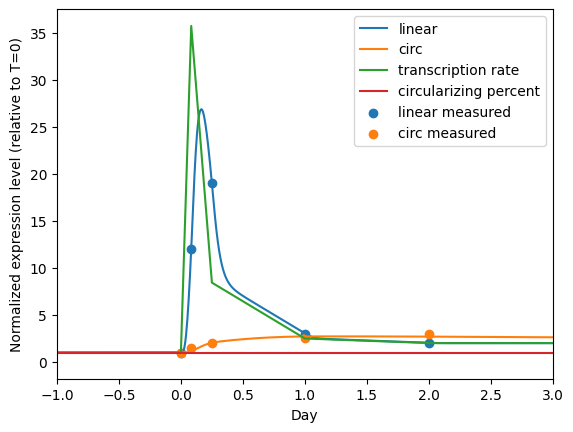

In [ ]:
change_day_list_c = [0]
circularizing_fraction_list = [.01]
params_dict = {
  'decay_rate_circ': .01,
  'decay_rate_linear': 25 ,
  'homer1a_fraction': 0.5 ,
  }

fit_system(params_dict,
               max_t_units, min_t_units,
               change_day_list_t,
               transcription_level_list,
               change_day_list_c,
               circularizing_fraction_list,
               day_list,
               circ_homer_levels,
               linear_homer_levels,
               suppress_plots = False,
               )
plt.xlim(-1, 3)

Initial parameter guesses: [36, 12, 2, 2, 0, 1.5, 0.01, 0.015, 0.01, 25, 0.5]
Hand fit RSS: 11.559633925345603


<ipython-input-51-b30b937a899e>:35: RuntimeWarning: divide by zero encountered in divide
  normalized_circular_amount = circ_homer/(circ_homer[zero_index])
<ipython-input-51-b30b937a899e>:35: RuntimeWarning: invalid value encountered in divide
  normalized_circular_amount = circ_homer/(circ_homer[zero_index])


fit parameter values: [35.51  8.62  2.42  1.97  1.86  1.97  0.04  0.50  0.17 28.89  0.27]
Best fit RSS: 0.1476222910722449
norm_linear_homer_levels: [ 1. 12. 19.  3.  2.]
homer1a_predicted: [ 1.         12.00207682 18.99067757  2.98924079  2.00396818]
circhomer_predicted: [1.         1.13106061 1.92978736 2.57906333 2.76616562]
norm_circ_homer_levels: [1.  1.5 2.  2.5 3. ]
squared_error_homer1a: 0.00022272785898200454
squared_error_circ: 0.20197561460702673
RSS: 0.20219834246600873
aic: -17.010912629208953
bic: -13.682476606274449


(-1.0, 3.0)

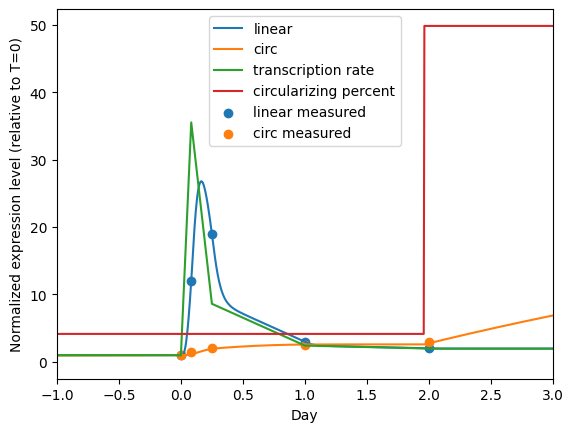

In [ ]:
change_day_list_c = [0, 1.5]
circularizing_fraction_list = [.01, .015]

params_dict = {
  'decay_rate_circ': .01 ,
  'decay_rate_linear': 25 ,
  'homer1a_fraction': 0.5 ,
  }

fit_system(params_dict,
               max_t_units, min_t_units,
               change_day_list_t,
               transcription_level_list,
               change_day_list_c,
               circularizing_fraction_list,
               day_list,
               circ_homer_levels,
               linear_homer_levels,
               suppress_plots = False,
               )
plt.xlim(-1, 3)

norm_linear_homer_levels: [1.  0.2 1.2 2.4 1. ]
homer1a_predicted: [1.         0.2        1.06713468 2.35744024 1.03679234]
circhomer_predicted: [1.         1.5        1.88075532 3.75895969 2.62362822]
norm_circ_homer_levels: [1.  1.4 2.2 3.2 3. ]
squared_error_homer1a: 0.020818202922154562
squared_error_circ: 0.5660088149371167
RSS: 0.5868270178592713
aic: -2.3561028406232793
bic: 1.5775033682993183


(6.5, 8.0)

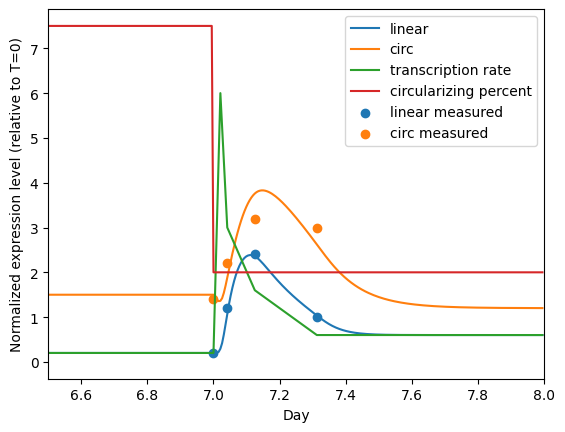

In [ ]:
#LD experiments
params_dict = {
  'decay_rate_circ': 10 ,
  'decay_rate_linear': 25 ,
  'homer1a_fraction': 0.5 ,
  }

steps_per_hour = 8
max_t_units = 8 #days
min_t_units = -30 #days

change_day_list_t = [.1, 7, 7+1/48, 7+1/24, 7+3/24, 7+7.5/24]
transcription_level_list = [.2, .2, 1.2*5, 1.2*2.5, 1.6, .6]

day_list = [0,7, 7+1/24, 7+3/24, 7+7.5/24]
circ_homer_levels = np.array([1, 1.4, 2.2, 3.2, 3])
linear_homer_levels = np.array([1, .2, 1.2, 2.4, 1])

change_day_list_c = [-.1, 0, 7.0]
circularizing_fraction_list = [.01, .075, .02]

compare_simulated_to_measured(params_dict, max_t_units, min_t_units,
                                  change_day_list_t, transcription_level_list,
                                  change_day_list_c, circularizing_fraction_list,
                                  day_list, circ_homer_levels,
                                    linear_homer_levels, suppress_plots = False)

plt.xlim(6.5,8)

Initial parameter guesses: [0.2, 0.2, 6.0, 3.0, 1.6, 0.6, 0, 0.01, 10, 25, 0.5]
Hand fit RSS: 9.174040011277214


<ipython-input-51-b30b937a899e>:34: RuntimeWarning: invalid value encountered in divide
  normalized_linear_amount = homer1a/(homer1a[zero_index])


fit parameter values: [5.00e+01 4.94e-01 4.99e+00 7.55e-01 5.62e+00 0.00e+00 0.00e+00 1.08e-02
 1.57e+01 3.80e+01 1.57e-08]
Best fit RSS: 3.2431852241256136
norm_linear_homer_levels: [1.  0.2 1.2 2.4 1. ]
homer1a_predicted: [1.         0.87154947 1.81551237 3.05681923 1.56796314]
circhomer_predicted: [1.         1.13859352 1.45351331 2.41805551 2.35011961]
norm_circ_homer_levels: [1.  1.4 2.2 3.2 3. ]
squared_error_homer1a: 1.5838278015339422
squared_error_circ: 1.6593574225916712
RSS: 3.2431852241256136
aic: 6.73970847755826
bic: 9.462974314504674


(-1.0, 10.0)

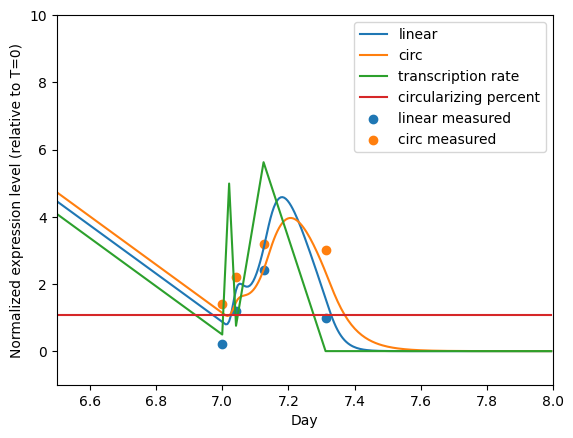

In [ ]:
change_day_list_c = [0]
circularizing_fraction_list = [.01]

params_dict = {
  'decay_rate_circ': 10 ,
  'decay_rate_linear': 25 ,
  'homer1a_fraction': 0.5 ,
  }

fit_system(params_dict,
               max_t_units, min_t_units,
               change_day_list_t,
               transcription_level_list,
               change_day_list_c,
               circularizing_fraction_list,
               day_list,
               circ_homer_levels,
               linear_homer_levels,
               suppress_plots = False,
               )

plt.xlim(6.5, 8)
plt.ylim(-1,10)

Initial parameter guesses: [0.2, 0.2, 6.0, 3.0, 1.6, 0.6, -0.1, 0, 7.0, 0.01, 0.075, 0.02, 10, 25, 0.5]
Hand fit RSS: 0.5868270178592713


<ipython-input-51-b30b937a899e>:34: RuntimeWarning: invalid value encountered in divide
  normalized_linear_amount = homer1a/(homer1a[zero_index])


fit parameter values: [ 9.03e-02  1.98e-01  7.60e+00  1.89e+00  2.55e+00  0.00e+00 -1.00e-01
  0.00e+00  7.00e+00  1.49e-02  1.20e-01  2.94e-02  6.96e+00  2.58e+01
  1.52e-08]
Best fit RSS: 0.1169009998195333
norm_linear_homer_levels: [1.  0.2 1.2 2.4 1. ]
homer1a_predicted: [1.         0.19639735 1.31302322 2.32599164 1.02396351]
circhomer_predicted: [1.         1.55893527 1.94245424 3.28036355 2.99629266]
norm_circ_homer_levels: [1.  1.4 2.2 3.2 3. ]
squared_error_homer1a: 0.01883871457866619
squared_error_circ: 0.0980622852408671
RSS: 0.1169009998195333
aic: -18.490129507585728
bic: -14.55652329866313


(-1.0, 12.0)

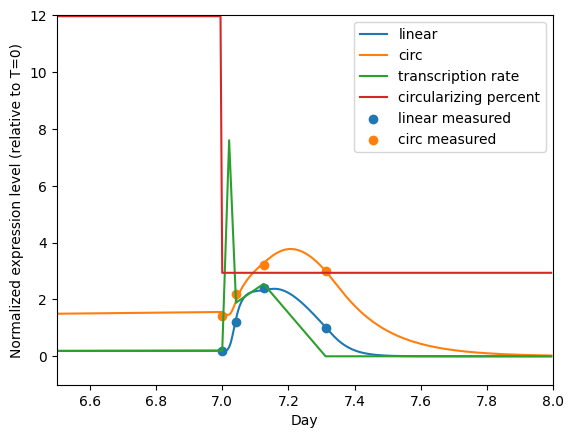

In [ ]:
change_day_list_c = [-.1, 0, 7.0]
circularizing_fraction_list = [.01, .075, .02]

#params_dict = {
#  'decay_rate_circ': 10 ,
#  'decay_rate_linear': 25 ,
#  'homer1a_fraction': 0.5 ,
#  }
fit_system(params_dict,
               max_t_units, min_t_units,
               change_day_list_t,
               transcription_level_list,
               change_day_list_c,
               circularizing_fraction_list,
               day_list,
               circ_homer_levels,
               linear_homer_levels,
               suppress_plots = False,
               )

plt.xlim(6.5, 8)
plt.ylim(-1, 12)

norm_linear_homer_levels: [1.         0.8        0.74413408 1.51396648 1.87039106 1.81005587
 3.68044693]
homer1a_predicted: [1.         0.72293095 0.66739456 1.34005344 1.65842976 1.62263571
 3.28232755]
circhomer_predicted: [ 1.          1.18784272  1.69996359  3.67418374  4.84892007  5.84098633
 12.89513451]
norm_circ_homer_levels: [ 1.          1.21488595  1.76590636  5.2304922   7.78271309  6.09603842
 10.54141657]
squared_error_homer1a: 0.28062728159594086
squared_error_circ: 16.63935695346966
RSS: 16.919984235065602
aic: 30.652133299601424
bic: 39.59893591421504


(0.0, 65.0)

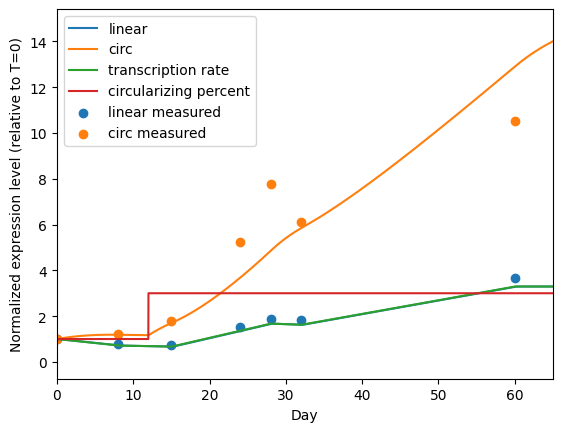

In [ ]:
#Developement/critical period experiments
params_dict = {
  'decay_rate_circ' : .1,
  'decay_rate_linear' : 10,
  'homer1a_fraction' : .5,
  'circularizing_fraction' : .01,
  }

steps_per_hour = 2
max_t_units = 70 #days
min_t_units = -10 #days

change_day_list_t = [8,15,24,28,32,60]
transcription_level_list = [.716, .666, 1.355, 1.674, 1.62, 3.294]

day_list = [0,8,15,24,28,32,60]
circ_homer_levels = np.array([.833, 1.012, 1.471, 4.357, 6.483, 5.078, 8.781])
linear_homer_levels = np.array([.895, .716, .666, 1.355, 1.674, 1.62, 3.294])

change_day_list_c = [0, 12]
circularizing_fraction_list = [.01, .03]

compare_simulated_to_measured(params_dict, max_t_units, min_t_units,
                                  change_day_list_t, transcription_level_list,
                                  change_day_list_c, circularizing_fraction_list,
                                  day_list, circ_homer_levels,
                                    linear_homer_levels, suppress_plots = False)


plt.xlim(0, 65)


Initial parameter guesses: [0.716, 0.666, 1.355, 1.674, 1.62, 3.294, 0, 0.01, 0.1, 10, 0.5]
Hand fit RSS: 106.27373772641197


<ipython-input-51-b30b937a899e>:34: RuntimeWarning: invalid value encountered in divide
  normalized_linear_amount = homer1a/(homer1a[zero_index])


fit parameter values: [1.06e+00 2.02e+00 2.79e+00 2.33e+00 1.16e+00 3.38e+00 0.00e+00 1.03e-02
 8.95e-03 4.63e+00 4.94e-10]
Best fit RSS: 9.87665748776018
norm_linear_homer_levels: [1.         0.8        0.74413408 1.51396648 1.87039106 1.81005587
 3.68044693]
homer1a_predicted: [1.         1.06022144 1.965361   2.75242778 2.38131949 1.28815585
 3.34430565]
circhomer_predicted: [ 1.          1.78012308  2.77218909  4.76606036  5.68173992  6.24005736
 10.93475826]
norm_circ_homer_levels: [ 1.          1.21488595  1.76590636  5.2304922   7.78271309  6.09603842
 10.54141657]
squared_error_homer1a: 3.739315224362451
squared_error_circ: 6.137342263397731
RSS: 9.87665748776018
aic: 17.115635395286127
bic: 24.14526602105397


(0.0, 65.0)

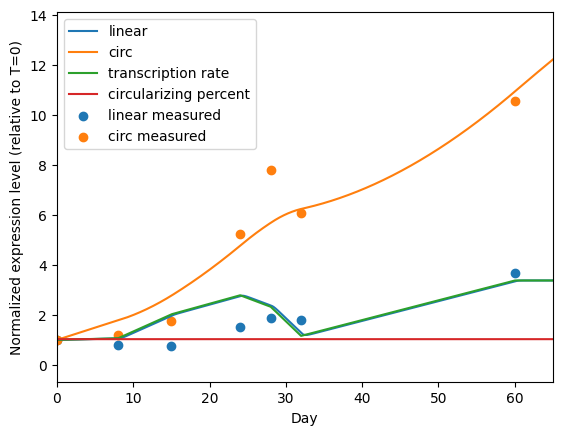

In [ ]:
change_day_list_c = [0]
circularizing_fraction_list = [.01]

fit_system(params_dict,
               max_t_units, min_t_units,
               change_day_list_t,
               transcription_level_list,
               change_day_list_c,
               circularizing_fraction_list,
               day_list,
               circ_homer_levels,
               linear_homer_levels,
               suppress_plots = False,
               )

plt.xlim(0, 65)


Initial parameter guesses: [0.716, 0.666, 1.355, 1.674, 1.62, 3.294, 0, 20, 0.01, 0.02, 0.1, 10, 0.5]
Hand fit RSS: 35.65956547676178


<ipython-input-51-b30b937a899e>:35: RuntimeWarning: invalid value encountered in divide
  normalized_circular_amount = circ_homer/(circ_homer[zero_index])
<ipython-input-51-b30b937a899e>:35: RuntimeWarning: divide by zero encountered in divide
  normalized_circular_amount = circ_homer/(circ_homer[zero_index])


fit parameter values: [ 8.73e-01  1.15e+00  2.04e+00  1.97e+00  1.81e+00  3.57e+00 -5.19e-03
  2.00e+01  2.76e-04  8.66e-04  3.26e-01  1.00e+01  5.00e-01]
Best fit RSS: 3.6475149507789144
norm_linear_homer_levels: [1.         0.8        0.74413408 1.51396648 1.87039106 1.81005587
 3.68044693]
homer1a_predicted: [1.         0.87658317 1.14217221 2.01974236 1.97768593 1.8179438
 3.5548144 ]
circhomer_predicted: [ 1.          0.95446847  1.08445119  4.8625812   6.09226892  6.13243467
 11.01831662]
norm_circ_homer_levels: [ 1.          1.21488595  1.76590636  5.2304922   7.78271309  6.09603842
 10.54141657]
squared_error_homer1a: 0.44746651783623737
squared_error_circ: 3.7539167408723477
RSS: 4.201383258708585
aic: 9.148990842677954
bic: 17.456736127676315


(0.0, 65.0)

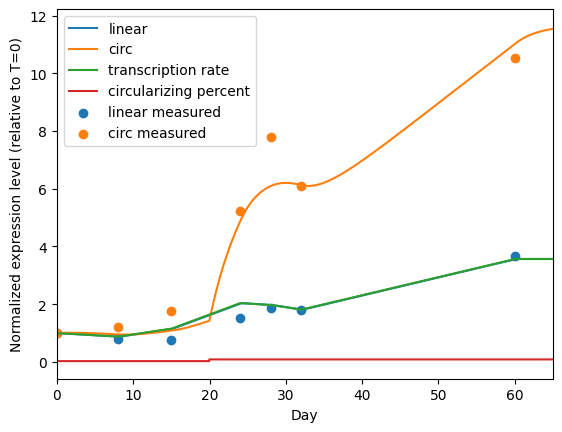

In [ ]:
change_day_list_c = [0, 20]
circularizing_fraction_list = [.01, .02]

fit_system(params_dict,
               max_t_units, min_t_units,
               change_day_list_t,
               transcription_level_list,
               change_day_list_c,
               circularizing_fraction_list,
               day_list,
               circ_homer_levels,
               linear_homer_levels,
               suppress_plots = False,
               )

plt.xlim(0, 65)

norm_linear_homer_levels: [1.  0.7 0.5]
homer1a_predicted: [1.         0.73551048 0.50396078]
circhomer_predicted: [1.         1.1467182  0.84560439]
norm_circ_homer_levels: [1.   1.2  0.75]
squared_error_homer1a: 0.0012766820062202595
squared_error_circ: 0.011979150007610283
RSS: 0.013255832013830543
aic: -12.690462843775329
bic: -15.189349213038668


(-1.0, 8.0)

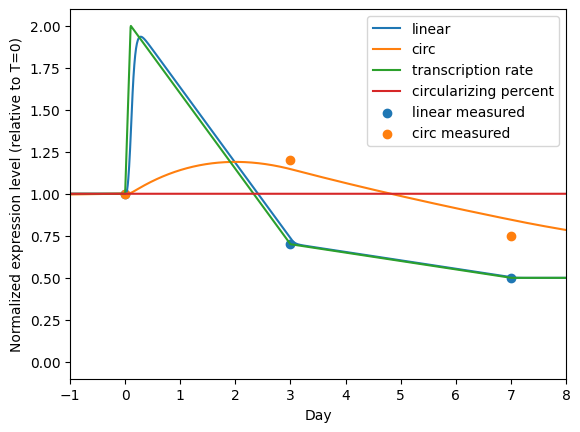

In [ ]:
#MD experiments
params_dict = {
  'decay_rate_circ': 0.2 ,
  'decay_rate_linear': 25 ,
  'homer1a_fraction': 0.5 ,
  'circularizing_fraction': .01 ,
  }

max_t_units = 10 #days
min_t_units = -20 #days

change_day_list_t = [0, 0.1, 3,7]
transcription_level_list = [1, 2, 0.7, 0.5]

day_list = [0, 3,7]
circ_homer_levels = np.array([1, 1.2, .75])
linear_homer_levels = np.array([1, .7, .5])
change_day_list_c = [0, 12]
circularizing_fraction_list = [.01, .03]

compare_simulated_to_measured(params_dict, max_t_units, min_t_units,
                                  change_day_list_t, transcription_level_list,
                                  change_day_list_c, circularizing_fraction_list,
                                  day_list, circ_homer_levels,
                                    linear_homer_levels, suppress_plots = False)

plt.xlim(-1, 8)

Initial parameter guesses: [1, 2, 0.7, 0.5, 0, 0.01, 0.2, 25, 0.5]
Hand fit RSS: 0.013255832013830543
fit parameter values: [1.00e+00 2.19e+00 6.58e-01 4.97e-01 0.00e+00 1.00e-02 3.07e-01 2.50e+01
 5.00e-01]
Best fit RSS: 3.735674218950359e-11
norm_linear_homer_levels: [1.  0.7 0.5]
homer1a_predicted: [1.         0.69999881 0.49999837]
circhomer_predicted: [1.         1.19999426 0.74999943]
norm_circ_homer_levels: [1.   1.2  0.75]
squared_error_homer1a: 4.084537095151584e-12
squared_error_circ: 3.3272205094352006e-11
RSS: 3.735674218950359e-11
aic: -136.81360305655937
bic: -138.68776783350688


(-1.0, 8.0)

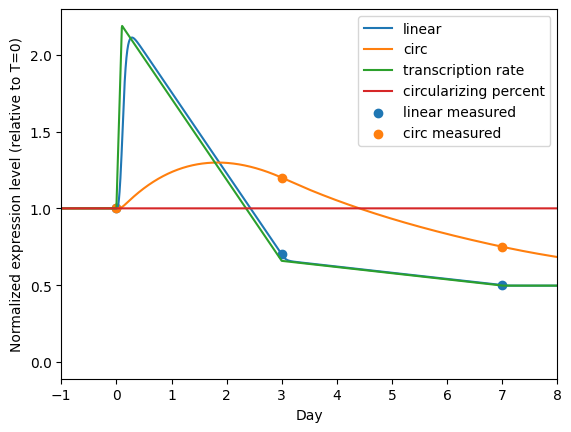

In [ ]:
change_day_list_c = [0]
circularizing_fraction_list = [.01]

fit_system(params_dict,
               max_t_units, min_t_units,
               change_day_list_t,
               transcription_level_list,
               change_day_list_c,
               circularizing_fraction_list,
               day_list,
               circ_homer_levels,
               linear_homer_levels,
               suppress_plots = False,
               )

plt.xlim(-1, 8)

Initial parameter guesses: [1, 2, 0.7, 0.5, 0, 20, 0.01, 0.02, 0.2, 25, 0.5]
Hand fit RSS: 0.013255832013830543
fit parameter values: [1.00e+00 2.19e+00 6.58e-01 4.97e-01 0.00e+00 1.00e+01 1.00e-02 2.00e-02
 3.07e-01 2.50e+01 5.00e-01]
Best fit RSS: 3.735674218950359e-11
norm_linear_homer_levels: [1.  0.7 0.5]
homer1a_predicted: [1.         0.69999881 0.49999837]
circhomer_predicted: [1.         1.19999426 0.74999943]
norm_circ_homer_levels: [1.   1.2  0.75]
squared_error_homer1a: 4.084537095151584e-12
squared_error_circ: 3.3272205094352006e-11
RSS: 3.735674218950359e-11
aic: -132.81360305655937
bic: -135.10424889505077


(-1.0, 8.0)

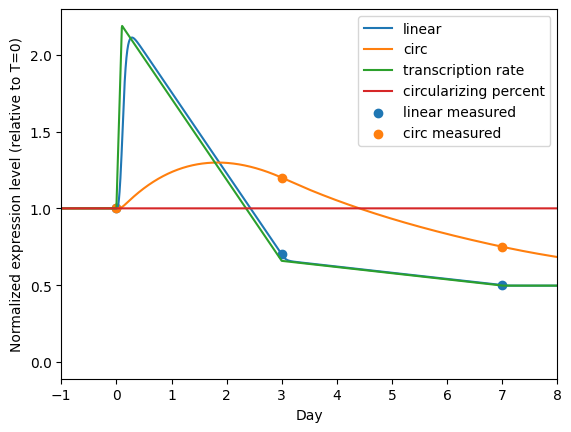

In [ ]:
change_day_list_c = [0, 20]
circularizing_fraction_list = [.01, .02]

fit_system(params_dict,
               max_t_units, min_t_units,
               change_day_list_t,
               transcription_level_list,
               change_day_list_c,
               circularizing_fraction_list,
               day_list,
               circ_homer_levels,
               linear_homer_levels,
               suppress_plots = False,
               )

plt.xlim(-1, 8)

Text(0, 0.5, 'Difference between AIC scores')

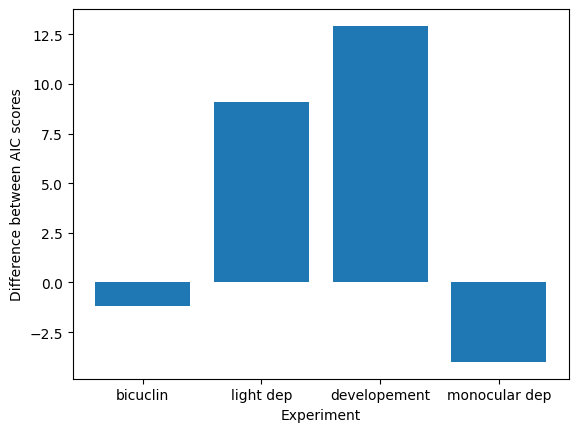

In [ ]:
bicuculin_no_pref_aic = -18.17
bicuculin_pref_aic = -17.01
bicuculin_diff = bicuculin_no_pref_aic - bicuculin_pref_aic
ld_no_pref_aic = 6.74
ld_pref_aic = -2.36
ld_diff = ld_no_pref_aic - ld_pref_aic
dev_no_pref_aic = 17.12
dev_pref_aic = 4.20
dev_diff = dev_no_pref_aic - dev_pref_aic
md_no_pref_aic = -136.8
md_pref_aic = -132.8
md_diff = md_no_pref_aic - md_pref_aic

bars = [bicuculin_diff, ld_diff, dev_diff, md_diff]
labels = ['bicuclin', 'light dep', 'developement', 'monocular dep']
plt.bar(labels, bars)
plt.xlabel('Experiment')
plt.ylabel('Difference between AIC scores')

In [ ]:
def func(guessed_params, fixed_params):
  return guessed_params[0]*fixed_params**2+guessed_params[1]*fixed_params+guessed_params[2]

def error_func(guessed_params, fixed_params, targets):
   return func(guessed_params, fixed_params)-targets
   #targets must be larger than guessed params

def error_func_scalar(guessed_params, fixed_params, targets):
  #print(guessed_params)
  rss = sum(abs(func(guessed_params, fixed_params)-targets)**2)
  #print(rss)
  return  rss

   #targets must be larger than guessed params? only for leastsq

x=np.array([1.0,2.5,3.5,4.0,1.1,1.8,2.2,3.7])
y=np.array([6.008,15.722,27.130,33.772,5.257,9.549,11.098,28.828])

initial_guess = (1.0,-1,3.0)

out = leastsq(error_func, initial_guess,args=(x,y))
print(out)
result = minimize(error_func_scalar, initial_guess,args=(x,y))
print(result.x)

(array([ 2.10811816, -1.06889584,  4.40567348]), 1)
[ 2.10811767 -1.06889343  4.40567106]


1440


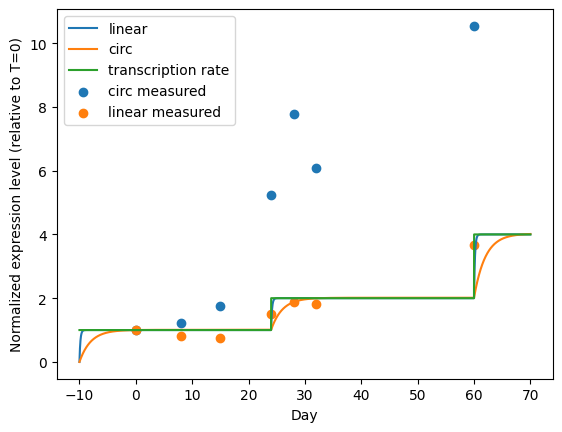

In [ ]:
change_day_list = [24,60]
transcription_level_list = [2,4]
production_rate = create_production_rate(transcription_level_list, change_day_list)

simulate_rna_concentrations(production_rate, decay_rate_circ, decay_rate_linear, max_t_units = max_t_units, min_t_units = min_t_units)

day_list = [0,8,15,24,28,32,60]
circ_homer_levels = np.array([.833, 1.012, 1.471, 4.357, 6.483, 5.078, 8.781])
linear_homer_levels = np.array([.895, .716, .666, 1.355, 1.674, 1.62, 3.294])
norm_circ_homer_levels = circ_homer_levels/circ_homer_levels[0]
norm_linear_homer_levels = linear_homer_levels/linear_homer_levels[0]

plt.scatter(day_list, norm_circ_homer_levels, label='circ measured')
plt.scatter(day_list,norm_linear_homer_levels , label='linear measured')
plt.xlabel('Day')
plt.ylabel('Normalized expression level (relative to T=0)')
plt.legend()


1440


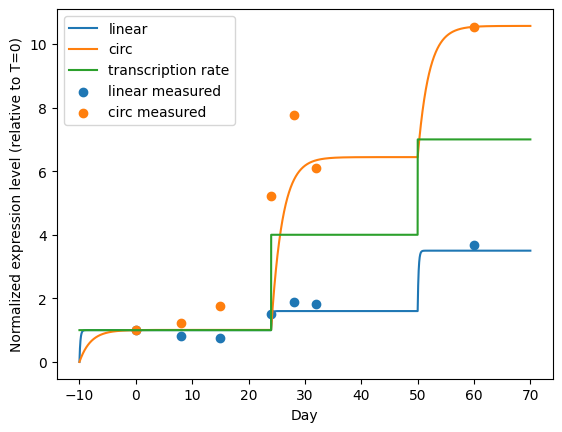

In [ ]:
change_day_list = [24,50]
transcription_level_list = [4,7]
preference_list = [.8, .75]
production_rate = np.ones(num_timesteps)
circ_preference = np.ones(num_timesteps)*.5
for i, transciption_level in enumerate(transcription_level_list):
  change_day = change_day_list[i]
  change_timestep = get_timestep_from_day_of_change(change_day)
  production_rate[change_timestep:] = transciption_level
  circ_preference[change_timestep:] = preference_list[i]
simulate_rna_concentrations(production_rate, decay_rate_circ, decay_rate_linear, max_t_units = max_t_units, min_t_units = min_t_units, circ_preference = circ_preference)

day_list = [0,8,15,24,28,32,60]
circ_homer_levels = np.array([.833, 1.012, 1.471, 4.357, 6.483, 5.078, 8.781])
linear_homer_levels = np.array([.895, .716, .666, 1.355, 1.674, 1.62, 3.294])
nrom_circ_homer_levels = circ_homer_levels/circ_homer_levels[0]
norm_linear_homer_levels = linear_homer_levels/linear_homer_levels[0]

plt.scatter(day_list,norm_linear_homer_levels , label='linear measured')
plt.scatter(day_list, nrom_circ_homer_levels, label='circ measured')
plt.xlabel('Day')
plt.ylabel('Normalized expression level (relative to T=0)')
plt.legend()

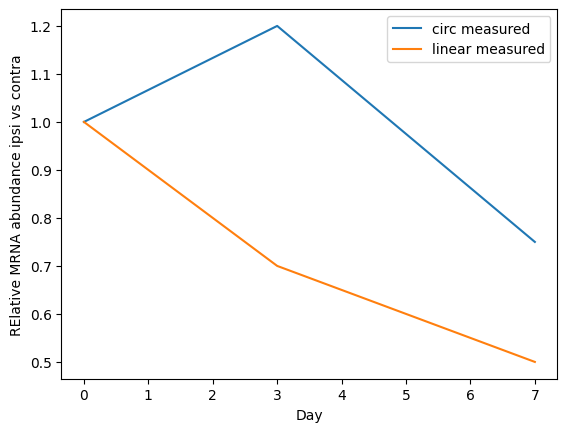

In [ ]:
day_list = [0, 3,7]
circ_homer_levels = np.array([1, 1.2, .75])
linear_homer_levels = np.array([1, .7, .5])

plt.plot(day_list, circ_homer_levels, label='circ measured')
plt.plot(day_list,linear_homer_levels , label='linear measured')
plt.xlabel('Day')
plt.ylabel('RElative MRNA abundance ipsi vs contra')
plt.legend()

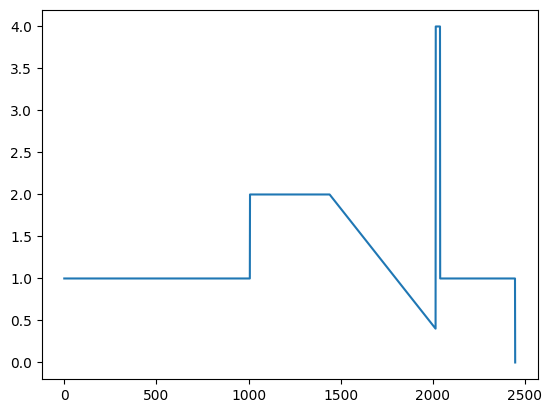

In [ ]:

#Recreate fig 2c
#time length = 60 days
#lets make each timestep 10 minutes
steps_per_hour = 6
max_t_units = 10 #days
min_t_units = -7
timesteps_before_0 = -1*min_t_units*24*steps_per_hour
num_timesteps = (max_t_units-min_t_units)*24*steps_per_hour

#Plasticity event at t=0. lets say it lasts for 3 days
first_change = 0*24*steps_per_hour+timesteps_before_0
second_change = 3*24*steps_per_hour+timesteps_before_0

#then reintruduce the light at day 7
third_change = 7*24*steps_per_hour+timesteps_before_0
#the rate increases for 2 hours
fourth_change = (7*24+1)*steps_per_hour+timesteps_before_0
fifth_change = (7*24+4)*steps_per_hour+timesteps_before_0

production_rate = np.zeros(num_timesteps)
production_rate[0:first_change] = 1
production_rate[first_change:-1] = 2
production_rate[second_change:-1] = -.4*np.arange(0,len(production_rate[second_change:-1]))/24/steps_per_hour+2 #lets say linear decay for the second half of the light deprivation
#y = mx+b - b is 2, m is -.9
production_rate[third_change:-1] = 4
production_rate[fourth_change:-1] = 4
production_rate[fifth_change:-1] = 1

plt.plot(production_rate)


1008


(array([0.        , 0.04166667, 0.08159722, ..., 1.00000006, 1.00000005,
        1.00000005]),
 array([0.        , 0.00357966, 0.0071469 , ..., 1.10568333, 1.10542381,
        1.1051652 ]))

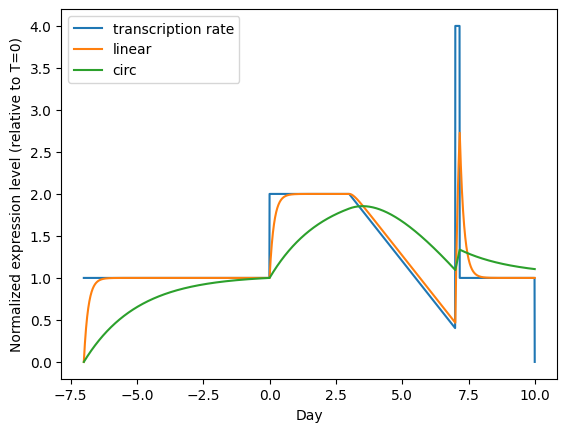

In [ ]:
simulate_rna_concentrations(production_rate, decay_rate_circ, decay_rate_linear, max_t_units = max_t_units, min_t_units = min_t_units)

In [ ]:
#dictated by the experimental timeline
right_eye_input #(0 to 1)
left_eye_input  #(0 to 1)

#fixed by the developement of the comissure
fraction_right_eye_input #(0 to 1)
fraction_left_eye_input #(0 to 1)
#^^ this actually doesn't seem fair... depends on whether you are in monocular or binocular

#determined by the model
fraction_right_eye_spines #(0 to 1%)
fraction_left_eye_spines  #(0 to 1%)

#compute activity to get the delta
right_eye_activation = right_eye_input*fraction_right_eye_input*fraction_right_eye_spines
left_eye_activation = left_eye_input*fraction_left_eye_input*fraction_left_eye_spines

binocular_activation = right_eye_activation+left_eye_activation


cortical_response = nonlinear_func(binocular_activation)
contra_response = nonlinear_func(right_eye_activation)
ipsi_response = nonlinear_func(left_eye_activation)


#calcium is proportional to cortical response
goal_cortical_binocular_response = 1

#this should do some integratino over many past timepoints
shift_activity = (goal_cortical_binocular_response - cortical_response)/goal_cortical_binocular_response
#^ Negative if too high, positive if too low.



#The change in spine fractions
loss = #function of protiens
gain = #function of protiens
gain_left = gain*left_eye_activation
gain_right = gain*right_eye_activation

delta_fraction_right = loss+gain_right
delta_fraction_left = loss+gain_left




Notes:
Need to consider that homer 1a might be able to be converted to circ homer
how do we deal with the whole cortex? BCM would cause the ipsi inputs to just keep getting weaker ... oh wait! The activity is the same, there are just fewer of them. So I have something wrong here.

so maybe simulate 100 possible synapses with a strength on each? different parts of cortex have diffrent availability - 50-50, 70-30, 100-0

homer1a is spine deconstruction
circ homer carries it around and helps with deconstruction
but what dictates spine gain? I guess BDNF? no, BDNF also seems to be for reshuffling
probably the other homers, Glua1 PSD95 and the like cause synapse formaiton. Produce more of those and the cell will start forming more or stronger synapses


In [ ]:
%%time
#fitting for bicuculin

decay_rates = np.logspace(-2, 1.6, 10) #.001 up to 50           #eventually do 50 instead of 10
fractions = np.linspace(0,1,11)  #0 to 1 intervals of .5        #eventually do 21 instead of 11
transcription_levels = np.round(np.logspace(-2, 1.6, 3), decimals=2)                 #eventually do 50 instead of 10 or 3
change_day_list = np.linspace(0,.3,4)                           #eventually do out to .8 with 9 instead of .4 with 3
starting_transciption_rate = 1

#just doing it the hacky for loop way first
#eventually may want to numpify and run them in tandem, but those vectors will get large
max_t_units = 3 #days
min_t_units = -10 #days

day_list = [0,2/24, 6/24, 24/24, 48/24]
circ_homer_levels = np.array([1, 1.5, 2, 2.5, 3])
linear_homer_levels = np.array([1, 12, 19, 3, 2])

#need to generate the different transcription curves to loop through
total_curves = len(transcription_levels)**(len(change_day_list)-1)
print(total_curves)
min_aic = 40
best_h1a_cont = None
best_circ_cont = None
best_params = None
best_curve = None

for curve_num in range(total_curves):
  transcription_level_list = [starting_transciption_rate]
  remainder = curve_num
  for i in range(len(change_day_list)-1):
    transcription_level_list.append(transcription_levels[int(remainder % len(transcription_levels))])
    remainder = remainder//len(change_day_list)

  #print(transcription_level_list)
  #generate the params_dict
  for decay_rate_circ in decay_rates:
    for decay_rate_linear in decay_rates:
      for homer1a_fraction in fractions:
        for circularizing_fraction in fractions:
          params_dict = {
            'decay_rate_circ': decay_rate_circ,
            'decay_rate_linear': decay_rate_linear ,
            'homer1a_fraction': homer1a_fraction ,
            'circularizing_fraction': circularizing_fraction ,
            }
          timesteps, homer1a_cont, circhomer_cont, aic = compare_simulated_to_measured(
                                  params_dict, max_t_units, min_t_units,
                                  change_day_list, transcription_level_list,
                                  day_list, circ_homer_levels,
                                    linear_homer_levels)
          if aic<min_aic:
            min_aic = aic
            best_h1a_cont = homer1a_cont
            best_circ_cont = circhomer_cont
            best_params = params_dict
            best_curve = transcription_level_list

print(min_aic)
print(best_h1a_cont)
print(best_circ_cont)
print(best_params)
print(best_curve)